## Sabina Hartnett
#### Methods testing for Thesis

This jupyter notebook features a number of methods I think could be relevant to my thesis -they are applied to two specific individuals and articles referencing them, but it could be well generalized to pronouns/gender generally (rather than individual names)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk # for text processing and analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import wordcloud # for a nice visual
from IPython.display import Image
from gensim import corpora, models

In [2]:
# see helper_functions.py file for additional functions - to save space here I import them
# (but here is a list of the relevant functions)
from helper_functions import *

##### My data:
Here are two sample csvs which include new york times articles which reference Joe Biden and Angela Merkel, respectively

In [3]:
## Read in dataframe of articles
biden_text = pd.read_csv('data/biden_nytimes1500.csv', usecols =['ArticleID', 'Text', 'Date']) #.drop('Unnamed: 0')
merkel_text = pd.read_csv('data/merkel_nytimes1500.csv', usecols =['ArticleID', 'Text', 'Date'])

**Data used here**

The data used here was collected from Proquest access from the University of Chicago Library. Each csv was downloaded as a random sampling of the articles returned which reference the two leaders. I plan to supplement the proquest data with scraped news data from the web (in progress) but the text analysis methods are relevant here

# Interpreting sentiment

The first step of this analysis is to contextualize the articles in which each figure is featured. As described in *The Circuit of Culture* by Du Gay, the meaning of a cultural artefact is itertively defined by its consumption an interpretation (2013). A cultural artefact (here, an article) is created within an exisiting cultural context, thus the articles analyzed here are sign replicas of news reporting on the individuals studied here with interpretants that reflect the social norms and cultural contexts in which the article is created. Thus, analyzing the sentiment of articles referencing each of the individuals will, on a large scale, provide insight into the type of context in which readers are exposed to these two featured individuals and the influence of that context on the readers interpretation of the individual (again, the Circuit of Culture). The cycle of news production and consumption actively influences the parallel creation and maintenance of culture and society. 

In [6]:
#Create a function which calculates the sentiment score for a text (passed in)
# and then apply that to the full texts for each article.
sid = SentimentIntensityAnalyzer()
def sentiment_score(text):
    return sid.polarity_scores(text)['compound']

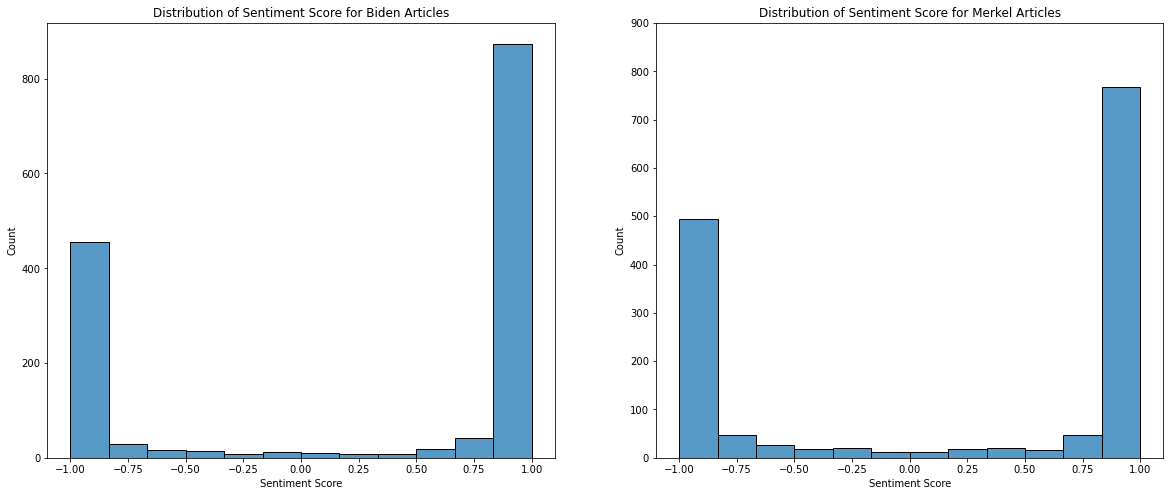

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig1 = sns.histplot(biden_text['Text'].apply(sentiment_score), ax=ax1)
fig1.set(xlabel = 'Sentiment Score', title = "Distribution of Sentiment Score for Biden Articles")
fig2 = sns.histplot(merkel_text['Text'].apply(sentiment_score),ax=ax2)
fig2.set(xlabel = 'Sentiment Score', title = "Distribution of Sentiment Score for Merkel Articles")
plt.ylim(0, 900)
plt.show()

### Figure 1a
        The distribution of Sentiment Scores for full articles which 
        reference Joe Biden and Angela Merkel, respectively.

Here, we can interpret sentiment distribution in aggregate and over the scope of full articles. Generally we can observe more negative sentiments in articles which reference Angela Merkel than in articles which reference Joe Biden. This could be due to a range of factors - international vs domestic politics (generally, perhaps NYTimes reports more positively about domestic politics and more negatively on international politics, or, perhaps this is more of a result of the 'newsworthy events' as described in the introduction: are articles on international events more often of negative sentiment (is negative sentiment correlated with significance? We see articles about war, famine, economic collapse but less often their counterparts - when countries are continuing on happy and healthy). This sentiment analysis is significant in understanding the contexts in which each of the two individuals appear and the affiliations that readers may make (interpretant) between the featured individual (object) and the thematic context (the rest of the article/ sign vehicle). 

In order to better understand the sentiment in referential moments in each article, we can zoom into these sentiments by focusing just on the sentences which reference each of the respective individuals.

In [8]:
# collect all of the sentences which reference each individual
merkel_sents = pd.Series(collect_reference_sentences(merkel_text['Text'], 'merkel', 3))
biden_sents = pd.Series(collect_reference_sentences(biden_text['Text'], 'biden', 3))

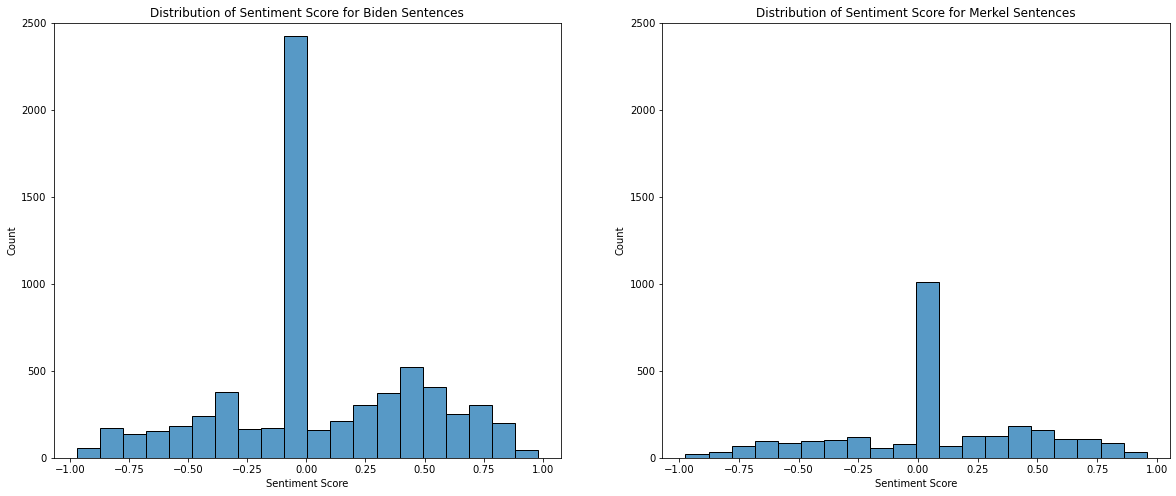

In [9]:
# plot the distribution of sentiment for the collected sentences
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
fig1 = sns.histplot(biden_sents.apply(sentiment_score), ax=ax1, bins =20)
fig1.set(xlabel = 'Sentiment Score', title = "Distribution of Sentiment Score for Biden Sentences")
fig1.set(ylim=(0, 2500))
fig2 = sns.histplot(merkel_sents.apply(sentiment_score),ax=ax2, bins =20)
fig2.set(xlabel = 'Sentiment Score', title = "Distribution of Sentiment Score for Merkel Sentences")
plt.ylim(0, 2500)
plt.show()

### Figure 1b
        The distribution of Sentiment Scores for sentences which 
        reference Joe Biden and Angela Merkel, respectively.

The most frequent sentiment for sentences which reference Joe Biden is overwhelmingly just left (negative) of neutral (0.0) whereas the most frequent sentiment for sentences which reference Angela Merkel is just right (positive) of neutral. This suggests that while articles in which Joe Biden is featured, the subject matter may be largely positive, but it is not necessarily a positive reference to him. While an article may influence a reader's affiliation thematically with an object of that article (a featured individual such as Joe Biden), a direct reference (the sentence in which Biden is mentioned) will have a stronger influence on the readers context for that individual (Gamson et al., 1992). 

Of course, a sentence level sentiment can result from a description of the individual in a correlated sentiment, or an incident of reporting on a context with that respective sentiment in which the individual is acting. For example: a sentence may have a negative sentiment if Joe Biden is being portrayed as having a mistake, but also if he is disappointed in someone else's mistake.

Overall, we see a similar distribution of sentiment in sentences referencing each of the targeted individuals. Interestingly, however, it can be observed that there are far more references to Joe Biden within the 1500 articles collected referencing him than there are references to Angela Merkel within the 1500 articles collected referencing her. Which raises the question - in what context are individuals referenced in articles? And why might there be inconsistencies in how often each of these individuals is referenced in a set number of articles?

In [10]:
print("Biden is mentioned {} times in the {} articles referencing him.".format(len(biden_sents), len(biden_text)))
print("Merkel is mentioned {} times in the {} articles referencing her.".format(len(merkel_sents), len(merkel_text)))

Biden is mentioned 6846 times in the 1500 articles referencing him.
Merkel is mentioned 2763 times in the 1500 articles referencing her.


After observing the distribution of sentiment in reference to each of the two individuals, I wanted to explore more of the semantic context. While sentiment may influence a reader's disposition towards an individual, semantic differences in content can be indicative of affiliations a reader will construct (or that pre-exist as universally-understood contexts). In order to better understand the thematic contexts for the sentences featuring each of the targeted individuals, I collected and tokenized the sentences (a bag of words approach) and created visuals of the most frequent words. These words can be understood as indicators of possibly relevant themes in referential moments.

In [11]:
biden_tokenized_reference_sents = biden_sents.apply(lambda x: word_tokenize(x))
merkel_tokenized_reference_sents = merkel_sents.apply(lambda x: word_tokenize(x))

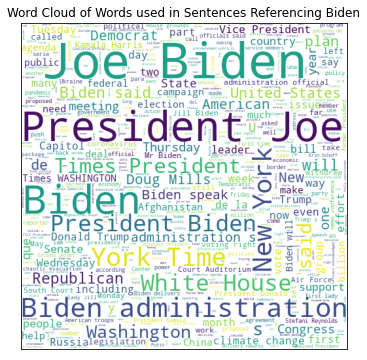

In [12]:
# for words used in full articles:
# wc_biden = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(biden_text['tokenized_text'].sum()))

# for words used in sentences referencing Biden:
wc_biden = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(biden_tokenized_reference_sents.sum()))
plt.figure(figsize=(6,6))
plt.title("Word Cloud of Words used in Sentences Referencing Biden")
fig = plt.imshow(wc_biden)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### Figure 2a
        A visual representation of the most frequent words appearing 
        in sentences from the biden corpus which reference Joe Biden.

Visible in Figure 2a are White House specific language, a number of political indicators, and additional active verbs. As the articles were collected during his term as President, it is intuitive that many of the sentences referencing Joe Biden would also reference his political position and actions (administration, leader, election, campaign), and relevant political bodies/locations (White House, Senate, Congress). Some additional themes of interest that appear in sentences referencing Joe Biden are international diplomatic relations (Afghanistan, China), and challenges faced during his term (Donald Trump (and the transition of power), pandemic). Finally, a third cluster of active verbs appear - these indicate that a significant portion of the sentences referencing Joe Biden report on the actions he has taken. Interestingly, many of these are relevant to speeches, remarks and announcements released from the White House. Rao et al. discovered that male individuals are likely to be used as direct subjects of articles (featured for their expertise and having their actions reported on), that so many active verbs appear in conjunction with reference to Joe Biden, this may be a signifier of this larger trend. 

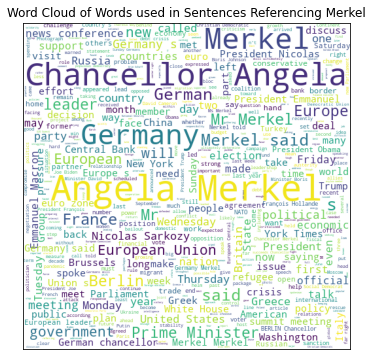

In [13]:
# for words used in full articles:
# wc_merkel = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(merkel_text['tokenized_text'].sum()))

# for words used in sentences referencing Merkel:
wc_merkel = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(merkel_tokenized_reference_sents.sum()))
plt.figure(figsize=(6,6))
plt.title("Word Cloud of Words used in Sentences Referencing Merkel")
fig = plt.imshow(wc_merkel)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

### Figure 2b
      A visual representation of the most frequent words appearing in 
      sentences from the merkel corpus which reference Angela Merkel.

In Figure 2b we can observe similar clustering, where there are direct references Bundestag (German parliament) specific language, political partners, and a collection of verbs. Similar to the trends observed in Figure 2a, the sentences which reference Angela Merkel also feature many of the signatures of political leadership in Berlin (Germany, Europe, Chancellor, Social Democrat). Interestingly, there are a significant number of references to political partners featured in Figure 2b (France (President Nicolas, President Emmanuel), Greece, Russia, Italy, Turkey, Prime Minister). This likely results either from references to Angela Merkel appearing in articles highlighting ‘international politics’ (and thus, the interaction of members of the European Union and significant coalition countries) or from a larger cultural indication of Angela Merkel as a cultural object. It is possible that Chancellor Merkel is culturally significant in the context of her role as a global leader, thus, international relations are significantly relevant to the interpretation of her as a cultural object. 

Finally, and perhaps most notably, we can observe a stark contrast in the verbs used in sentences in which Merkel is featured compared to those in which Biden is referenced. Where, in the biden_sentences there were a number of action verbs referencing speeches, debates and deliveries from the President, the verbs common in sentences which reference the Chancellor suggest a more passive role. As Rao et al. observed, a significant component of gender bias in news reporting comes from the context in which individuals of various genders are referenced. Where a male might be featured for an action he took, a woman is often used as an object to elicit an emotional response from the reader (where, in many cases her individual relation to the event/article is irrelevant) (Rao et al., 2021). That Merkel is referenced as a recipient of ‘pressure’, a subject to ‘crisis’, is a divergence from the active verbs of Biden ‘plan[ning]’, ‘support[ing]’ and ‘deliver[ing]’ as a leader. This pattern has been observed in qualitative content analysis of news media (Collins et al., 2011; Rao et al., 2021) as well as computational methods of content analysis (including word embeddings and topic models) (Kozlowski et al., 2019; Bhatia, 2017).


Finally, in order to contextualize these word co-occurrence in a deeper semantic sense, this study implements LDA topic modeling (from the Gensim python package) to observe some of the most significant topics in sentences referencing each of the political leaders. Since the analysis conducted with word co-occurrence was based on a ‘bag of words’ approach, and human interpreters integrate grammar and a larger semantic context into their interpretation, it is relevant to also study the semantics of reference sentences at sentence level.

So we can ask: what topics emerge in the sentences referencing each leader?

In [13]:
# Initialize Series of lemmas as Gensim Dictionary for further processing
m_dictionary = corpora.Dictionary([i for i in merkel_tokenized_reference_sents])

#m_dictionary = corpora.Dictionary([i for i in merkel_tokenized_reference_sents])
# Convert dictionary into bag of words format: list of (token_id, token_count) tuples
m_bow_corpus = [m_dictionary.doc2bow(text) for text in merkel_tokenized_reference_sents]

In [14]:
# Fit optimal LDA Model based on bag of words counts for each token and return weights
# using single-core processing. After multiple iterations, it appears that 20 is ideal
#m_ldamodel = models.ldamodel.LdaModel(m_bow_corpus, num_topics = 20, id2word=m_dictionary, passes=20, iterations=400)
#m_ldamodel.save('merkel_lda20_i400.model')
m_ldamodel = models.ldamodel.LdaModel.load('merkel_lda20_i400.model')
m_sents_by_topic = top_sents_by_topic(merkel_tokenized_reference_sents, m_ldamodel, m_bow_corpus, ntop=10)

Topic 0
794     [El, miércoles, Scholz, tomará, posesión, como...
1913    [Photograph, by, Fabrizio, Bensch, Reuters, B1...
1077    [Photograph, by, Alex, Wong, Getty, Images, B1...
999     [Photograph, by, Yves, Herman, Reuters, Chance...
878     [The, magazine, described, the, Merkel, doctri...
1565    [Reich, Ranicki, addressed, the, German, Parli...
1388    [The, flamboyant, German, designer, given, to,...
1413    [MERKEL, who, has, met, these, men, before, an...
210     [He, ignored, calls, to, stay, from, Chancello...
1272    [Merkel, spoke, as, the, true, heiress, of, th...
dtype: object
*******************************
Topic 1
107     [Erin, Schaff, The, New, York, Times, Chancell...
184     [Erin, Schaff, The, New, York, Times, Chancell...
411     [Erin, Schaff, The, New, York, Times, Chancell...
1522    [Erin, Schaff, The, New, York, Times, Chancell...
2399          [Merkel, joined, him, in, scrutinizing, Ms]
927     [Merkel, welcomed, hundreds, of, thousands, of...
185     [E

Topic 13
1253    [Merkel, remains, firmly, opposed, to, the, id...
2080    [Merkel, remains, opposed, to, the, idea, argu...
258     [Merkel, imposed, a, moratorium, on, new, nucl...
1245    [Merkel, would, like, to, return, stability, a...
2695                            [Merkel, visibly, tensed]
2143    [Merkel, also, discussed, negotiations, with, ...
330     [As, Other, Western, States, Have, Had, to, Fo...
1547    [Merkel, said, challenging, the, leaders, to, ...
2072    [Most, of, all, Merkel, would, like, to, retur...
1092    [His, and, hers, Clockwise, from, top, Chloé, ...
dtype: object
*******************************
Topic 14
456     [Merkel, and, then, Mr]
90            [Merkel, and, Mr]
447           [Merkel, and, Mr]
546           [Merkel, and, Mr]
761           [Merkel, and, Mr]
986           [Merkel, and, Mr]
1310          [Merkel, and, Mr]
1362          [Merkel, and, Mr]
1675          [Merkel, and, Mr]
2089          [Merkel, and, Mr]
dtype: object
**********************

### Figure 3a
    Topics created by LDA topic model for 20 topics from a corpus
    of sentences referencing Angela Merkel.

In [75]:
# This topic number can be changed to look more closely at the top 10
#sentences most similar to each of the 20 topics for the sentences
#which reference Chancellor Merkel
TOPIC_NUMBER = 6
for sentence_loc in m_sents_by_topic[TOPIC_NUMBER]:
    str_sent = ' '.join(merkel_tokenized_reference_sents.loc[sentence_loc])
    print(str_sent)

His mother Berthe Mballa a migrant from Cameroon says she chose the name for him because Merkel is my savior
Merkel hosted the leaders in the port city 's elegant Elbe Philharmonic Hall to hear Beethoven 's Ninth Symphony plumes of smoke rose from the center of the city as the protests escalated
Merkel and other high ranking government officials
Merkel seems keenly aware that the Cologne episode has awoken doubts even among those who welcome the new migrants and on Saturday she proposed toughening expulsion laws for foreigners who commit crimes
Chancellor Angela Merkel and her predecessor Gerhard Schroder have joined Chinese officials for well publicized rides on the Shanghai train during visits to China
Merkel who chose Mr
The issue is a sensitive one in Germany and Chancellor Angela Merkel and other high ranking officials have repeatedly denounced the anti immigrant movement widely known by its German acronym Pegida which stands for Patriotic Europeans Against the Islamization of the

In Topic 6 specifically, we observe references to one of the most memorable decisions made by (/actions taken by) Merkel during her time in office: immigrant and refugee policy during and following the 2015 Refugee Crisis. In the sentences included here (the 10 most relevant to this topic) we can observe some of the language patterns that exist surrounding Merkel and one of the defining moments for her as a cultural artefact. The first sentence (most closely affiliated with the topic) included here implies admiration from a migrant and her son from Cameroon of Chancellor Merkel, there are other references, additional sentences describe politicians denouncing anti-immigrant movements, intelligence (and reference [4] to a hate crime committed by a member of the german army posing as a refugee), and protests within Germany. This issue has proven controversial and is partially what made Merkel such a cultural icon in many American homes. 

Additionally, Topic 10 of this LDA model features sentences describing the influence and legacy of Angela Merkel. Meaning that she can be studied both as a cultural artefact (whose (semantic/contextual) reference iteratively alters the interpretation of her as a cultural object), she also is commonly understood to hold an exisiting meaning.

A few additionally interesting Topics are Topic 11 (which describes Merkel's early career and Germany reckoning with her departure from office), Topic 12 (which references Schultz (Merkels successor) and his will to recreate much of Merkel's political persona as well as politics), Topic 3 (which describes moments of disappointment and dissatisifcation with Merkel as a leader), and Topic 4 (which includes moments of interaction between Merkel and other world leaders). 

In [19]:
# Initialize Series of lemmas as Gensim Dictionary for further processing
b_dictionary = corpora.Dictionary([i for i in biden_tokenized_reference_sents])
# Convert dictionary into bag of words format: list of (token_id, token_count) tuples
b_bow_corpus = [b_dictionary.doc2bow(text) for text in biden_tokenized_reference_sents]

In [55]:
# For direct comparison, we'll use a similar number of topics
#biden_ldamodel = models.ldamodel.LdaModel(b_bow_corpus, num_topics = 20, id2word=b_dictionary, passes=20, iterations=400)
#biden_ldamodel.save('biden_lda20_i400.model')
biden_ldamodel = models.ldamodel.LdaModel.load('biden_lda15_i400.model')
b_sents_by_topic = top_sents_by_topic(biden_tokenized_reference_sents, biden_ldamodel, b_bow_corpus, ntop=10)

Topic 0
4951    [Biden, hung, a, picture, of, President, Frank...
4175    [Biden, will, need, congressional, and, indepe...
208                                  [Joe, Biden, D, Del]
4729                                 [Joe, Biden, D, Del]
179                                  [Joe, Biden, D, Del]
4731                                 [Joe, Biden, D, Del]
3136    [Biden, delivered, a, fierce, speech, promisin...
874           [So, how, do, you, get, Biden, and, the, D]
1736    [Biden, the, largest, public, works, bill, sin...
2804    [Joe, Biden, ran, on, unity, and, bipartisanship]
dtype: object
*******************************
Topic 1
3004            [Biden, signed, the, law, New, York, Gov]
1773    [Biden, to, declare, climate, change, a, natio...
5483    [Aunque, Biden, amplió, la, fecha, de, retirad...
5386    [Biden, Could, Too, column, May, 2):A, child, ...
4627    [Biden, said, referencing, the, senator, of, K...
4238         [It, ’s, simply, simply, wrong, Biden, said]
5979      

Topic 13
2415    [El, presidente, Biden, calificó, la, detenció...
6506    [Combatir, la, corrupción, es, parte, de, la, ...
1553                                 [Biden, needs, both]
3898    [Biden, delayed, the, admissions, designation,...
5753    [Loukissas, dijo, que, había, pasado, algún, t...
2405    [Pero, si, de, algo, sirven, las, lecciones, d...
3000    [Biden, said, celebrating, the, bill, on, the,...
4534    [President, Joe, Biden, and, Vice, President, ...
1979    [El, gobierno, de, Biden, se, ha, comprometido...
2441         [Biden, was, frustrated, with, the, process]
dtype: object
*******************************
Topic 14
4810                  [Biden, had, finally, come, around]
2599                                [Biden, had, a, cold]
995                             [Biden, had, disregarded]
6591                               [Biden, had, proposed]
4708    [In, meetings, Biden, and, Dole, encouraged, Sen]
1089    [Biden, had, more, than, 80, million, votes, t...
1320    

### Figure 3b
    Topics created by LDA topic model for 15 topics from a corpus
    of sentences referencing Joe Biden.

In [73]:
# This topic number can be changed to look more closely at the top 10
#sentences most similar to each of the 15 topics for the sentences
#which reference President Biden
TOPIC_NUMBER = 14
for sentence_loc in b_sents_by_topic[TOPIC_NUMBER]:
    str_sent = ' '.join(biden_tokenized_reference_sents.loc[sentence_loc])
    print(str_sent + '\n')

Biden had finally come around

Biden had a cold

Biden had disregarded

Biden had proposed

In meetings Biden and Dole encouraged Sen

Biden had more than 80 million votes to Mr

President Biden had an ambitious agenda to remake the economy

Biden could rightly claim to be presiding over a booming economy

Biden argues could shift the landscape of the economy

You won with 79 million votes and Biden had 68 million he recalled



Interestingly, here we see a sample of similar syntax causing sentences to cluster together. Interesting here, apart from the predictions made about gender representation from Bhatia (2017) and Calliskan (2017), many sentences which include Biden (male, in a leadership position) use passive voice; a syntax which does not match the expectations for gender representation as a sign replica of gendered patterns in the world.

15 topics proved to be more coherent than increasing to 18 or 20 (and better than decreasing to 12 - with over 6,000 sentences it doesn't seem like topics will be specific enough to parse with under 12), but still had many 'junk' topics which made interpretation difficult. Nonetheless there were a few coherent topics and interesting trends to observe. Namely, Topic 2 referenced Biden in discussion with other world leaders (and the UN) and Topic 3 similarly included sentences discussing international relations (other world leaders, travel, G20). This signals that news media is interested in these world leaders (Biden and Merkel) and that being a *world* leader is a significant component of each of them as cultural artefacts. Thus, both feature a cluster of semantic coherence (topics) which discuss international relations and their role as international leaders. 

Additionally, Topic 10 discusses a mixing of political parties and situates Biden in the exisiting political state in the US and Topic 8 includes sentences which discuss awards, pardoning and interactions with the pope/religion. 

# Conclusion

Overall, this study interprets news media as a cultural object. Within the *Circuit of Culture* introduced by Du Gay 2013, news media is a cultural object which is consumed and produced in an iterative and reactive way. There are many stakeholders involved in the production (including news media companies, reporters, stakeholders in the events reported on, advertising bodies) and regulation (including news media companies, politicians) of news media. News is produced both in reaction to world events, as well as in the context of popular and 'accceptable' (as determined by the aforementioned stakeholders) content and language. The cultural context in which news is reported influences what is considered significant, palatable and engaging to readers (what sells) (Gamson, 1992) as well as to political entities (Entman, 2010).


This study interprets the sentiment and semantics surrounding two cultural artefacts (two significant world leaders) and their portrayal as objects in news media. By exploring the sentiment surrounding references to each of the two leaders, we can observe generally similar behavior on both an article and sentence level of interpretation. This suggests that a leader, as a sign-replica of a larger legisign (a politician) is portrayed in contexts of similar sentiment (across two differing genders and geo-political roles). Then, by analyzing the semantic context of the two leaders in their respective features in news media, we found evidence of common trends in gender representation. In the first semantic analysis, a visual representation of co-occurance frequency for each of the two leaders, there were a number of similarities but also a few notable differences. The context in which the two leaders were referenced appeared to be largely similar (with reference to other political leaders (they interact with), their political 'home' (white house / Berlin), and their respective political stance (democrat / social democrat). However, as has been observed in a number of news media and text-analysis studies (Caliskan et al., 2017; Collins, 2011; Kozlowski et al., 2019; Rao et al., 2021), it appeared that there were notable differences (correlated with trends in gender representation) in the level of action described by each leader. Where Joe Biden saw a higher frequency of co-occurance with action verbs related to speeches, debates and presentations. 

Finally, to tie the study together, we created LDA topic models for the sentences referencing each of the two leaders to qualitatively observe the clusters of topics 'most relevant' to each leader. This analysis models the cognitive affiliations that readers would make after consuming the text of these articles (common topics in the topic model would be highly affiliated with the individual as a cultural object in a reader). Through this analysis we observed a number of coherent topics (and a lot of junk - which is understandable since the topics were created from discreet sentences (LDA is often applied to full length documents). Ultimately, both leaders were discussed at the scale of their cultural significance (in their interactions with global bodies and other leaders) which suggests supports that they are each conventionally understood cultural icons.

To understand the impact that these culutral legisign replicas have, we must consider the way that news media is consumed. Readers actively engage with news media and interpret meaning from the text (both in content and semantics) as well as images that they consume. In this decoding, readers bring their own experiences, context, and biases which gives the individual agency in interpreting the news (Gamson, 1992; Hall, 2003). This active interpretation, in turn, influences the individual, their perspective of the world (and the news as a means of engaging with the world), and their actions within that context. That is to say, the cycle of news production and consumption actively influences the parallel creation and maintenance of culture and society. As introduced throughout this study, the Circuit of Culture continues to be relevant in understanding the impact of news media on the cultural artefacts featured in articles.

### Bibliography 

Bhatia, Sudeep. "Associative judgment and vector space semantics." Psychological review 124, no. 1 (2017): 1.

Caliskan, Aylin, Joanna J. Bryson, and Arvind Narayanan. "Semantics derived automatically from language corpora contain human-like biases." Science 356, no. 6334 (2017): 183-186.

Entman, Robert M. "Media framing biases and political power: Explaining slant in news of Campaign 
2008." Journalism 11, no. 4 (2010): 389-408.

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. Proceedings of the National Academy of Sciences, 115(16), E3635-E3644.


Gamson, W. A., Croteau, D., Hoynes, W., & Sasson, T. (1992). Media images and the social construction of reality. Annual review of sociology, 18(1), 373-393.

Hall, Stuart. Encoding/decoding. Routledge, 2003.

Kozlowski, A. C., Taddy, M., & Evans, J. A. (2019). The geometry of culture: Analyzing the meanings of class through word embeddings. American Sociological Review, 84(5), 905-949.


Manovich, L. (2020). Cultural analytics. Mit Press.

Ross, K., & Carter, C. (2011). Women and news: A long and winding road. Media, Culture & Society, 33(8), 1148-1165.

Schudson, M. (1989). The sociology of news production. Media, culture & society, 11(3), 263-282.

TOMASELLO

Vogler, D., & Schwaiger, L. (2021). Situational effects of journalistic resources on gender imbalances in the coverage of Swiss news media: A longitudinal analysis from 2011 to 2019. Journalism, 14648849211036309.